In [ ]:
###this notebook requires downloading SFS_code. ###see http://sfscode.sourceforge.net/SFS_CODE_doc.pdf

####packages
import numpy as np
import pandas as pd
import os
import re
import scipy
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors
import PIL
from matplotlib import colors
from IPython.display import IFrame
from datetime import datetime
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape
from keras.utils.np_utils import to_categorical
from keras.callbacks import History 
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

##### settings
###general
verbose=0
verbose_keras=0
recreate_sfs_sequences=1 ###set to zero if aim is to re-use earlier created sequences
subset_to_equal_size=1

##iterations 
num_iterations_strong=100
num_iterations_historic=100
num_iterations_weak=250 ###roughly 50% RR
num_iterations_partial=1000 ###roughly 10% RR
num_iterations_neutral=360

final_subset_size_strong=80
final_subset_size_historic=80
final_subset_size_neutral=320
final_subset_size_weak=80
final_subset_size_partial=80

write_to_file=0
datestr=str(datetime.now().strftime("%y%m%d")); print(datestr)
plotting_activated=0
write_out_prediction_file=0
show_examples=0
save_df_predictions=1
reload_model=0

###keras settings
epochs=500 
selectmodel=1
batch_size = 48
harmonize=0 
test_size=0.2
seed_value_keras=1
shuffle_seed_testtrainshuffle=1

###sfs settings
seed_sfs=2 
number_pops=4
locus_length=1000
sample_size=100
number_of_sampled_chromosomes=sample_size*2
##selection strenght
sel_strength_hard=2000
sel_strength_historic=2000
sel_strength_weak=400
sel_strength_partial=100
##endtimes
end_time_hard=0.2
end_time_weak=0.2
end_time_historic=0.4
end_time_partial=0.15
end_time_neutral=end_time_hard
##definition of partial sweeps
partial_low_cutoff=0.33
partial_high_cutoff=0.8

###plotting
imagename="pdf_sfs_out_new.pdf"
ax_base_shape = (1.0, 1.8)
height_image=50
width_image=80
dpi_image=80
images_per_row=5; number_of_columns=3
numPlotsOnPage=15
standard_colours="on"
image_resize=(200,40)
title_perf_graph="simulation_performance"
FONT_SIZE = 35
PLT_RCPARAMS_DICT = {'legend.fontsize': FONT_SIZE,'axes.labelsize': FONT_SIZE,'axes.titlesize':FONT_SIZE,'xtick.labelsize':FONT_SIZE,'ytick.labelsize':FONT_SIZE}

%run SFS_functions_public_V2.py

In [7]:
def reallocate_neutral_scenarios_to_folds(inputlist):
    interim_list=list(set(inputlist))
    interim_list.remove("sel_neutral") ###remove sel_neutral
    inputlist=np.array(inputlist)
    inputlist[inputlist=="sel_neutral"]=np.random.choice(interim_list, np.sum(inputlist=="sel_neutral"))
    return(inputlist)

def create_predictions_dataframe(id_test,source_simulations_test,adjusted_source_simulations_test,y_test,divergence_midpoint_test,x_test_input,x_test_classes_input,show_mispredictions,write_out):
    df_predictions_sim=pd.DataFrame(zip(id_test,source_simulations_test,adjusted_source_simulations_test,y_test,divergence_midpoint_test,x_test_input,x_test_classes_input))
    df_predictions_sim.columns=["id","source","adjusted_source","label","div_mid","pred_prob","pred"]
    df_predictions_sim["acc"]=df_predictions_sim["label"]-df_predictions_sim["pred"]
    print(1-np.true_divide(np.sum(df_predictions_sim["acc"]!=0),df_predictions_sim.shape[0]),"accuracy")
    if show_mispredictions==1: 
        df_predictions_sim[df_predictions_sim["acc"]!=0]
    df_predictions_sim['pred'] = df_predictions_sim['pred'].apply(lambda x: x[0])
    print(pd.crosstab(df_predictions_sim['label'], df_predictions_sim['pred'], rownames=['Actual'], colnames=['Predicted']))
    if write_out==1:
        df_predictions_sim.to_csv("df_predictions_sim.csv")
    print("The predictive accuracy of the model on the test sest is {} percent".format(100*np.true_divide(np.sum(df_predictions_sim["label"]==df_predictions_sim["pred"]),df_predictions_sim.shape[0])))
    return(df_predictions_sim)

def create_crosstab(df,criterion):
    df = df[df['adjusted_source']==criterion]
    print("accuracy is {}".format(1-np.true_divide(np.sum(df["acc"]!=0),df.shape[0])))
    confusion_matrix = pd.crosstab(df['label'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
    print (confusion_matrix)

def update_dataframe_2(df,criterion):
    test_values,predicted_values=subset_and_get_test_and_predicted_values(df,criterion,use_probability_output=0)
    n_samples=len(test_values)
    ACC,TPR,TNR=accuracy_and_cm(test_values,predicted_values)
    print(n_samples,ACC,TPR,TNR,"final values")
    return n_samples,100*ACC,100*TPR,100*TNR

def simulation_performance_dataframe(df_predictions_sim,datestr,write_out):
    interim_list=list(df_predictions_sim.adjusted_source.unique()) ###get all possible outcomes 
    columns=["n_samples","Accuracy","TPR","TNR","AUC"]
    df_roc = pd.DataFrame(index=interim_list, columns=columns)
    df_roc = df_roc.fillna(0.0) # with 0s rather than NaNs
    for criterion in interim_list:     ###populate dataframe
        print(criterion)
        df_roc.loc[criterion]["n_samples"],df_roc.loc[criterion]["Accuracy"],df_roc.loc[criterion]["TPR"],df_roc.loc[criterion]["TNR"]=update_dataframe_2(df_predictions_sim,criterion)  
    df_roc.round(1) ###round numbers
    #df_roc.sort_values(by=['sel_strong', "sel_historic", 'sel_weak',"sel_partial","all"])
    title_graph="SFS_simulation_results_"+datestr+".csv"
    if write_out==1:
        df_roc.to_csv(title_graph)
    return(df_roc)

def obtain_roc_values(test_values,predicted_values):
    fpr, tpr, _ = roc_curve(test_values,predicted_values)
    roc_auc = auc(fpr, tpr)
    return(fpr, tpr,roc_auc)

def subset_and_get_test_and_predicted_values(dg,criterion,use_probability_output=0):
    df=dg.copy()
    df = df[df['adjusted_source']==criterion]
    #predicted_values=[x[0] for x in df['pred_prob']]
    if use_probability_output==0:
        predicted_values=df['pred']
    else:
        predicted_values=df['pred_prob'].str.strip('[]').astype(float)
    #print(predicted_values)
    test_values=df.label
    #print(test_values)
    return test_values,predicted_values

def draw_roc_curve(df,criterion,title,color):
    test_values,predicted_values=subset_and_get_test_and_predicted_values(df,criterion,use_probability_output=1)
    fpr, tpr,roc_auc =obtain_roc_values(test_values,predicted_values)
    plt.plot(fpr, tpr, color=color,lw=2, label=title % roc_auc)

def plot_roc_curve(df_predictions_simm,datestr,write_out):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    draw_roc_curve(df_predictions_sim,"all","'all (AUC = %0.3f)'","aqua")
    draw_roc_curve(df_predictions_sim,"sel_weak","'weaker (AUC = %0.3f)'","orange")
    draw_roc_curve(df_predictions_sim,"sel_historic","'historic (AUC = %0.3f)'","red")
    draw_roc_curve(df_predictions_sim,"sel_partial","'partial (AUC = %0.3f)'","green")
    draw_roc_curve(df_predictions_sim,"sel_strong","'stronger (AUC = %0.3f)'","blue")
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    title_graph="SFS_simulation_roc_curves_"+datestr+".png"
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')#; plt.title(title_graph)
    plt.legend(loc="lower right")
    if write_out==1:
        plt.savefig(title_graph)
    plt.show()

In [1]:
if recreate_sfs_sequences==1:

    ##strong selection
    !sfs_code $number_pops $num_iterations_strong --seed $seed_sfs -L 1 $locus_length -TS 0 0 1 -TS 0 0 2 -TS 0 0 3 -a N --outfile sfs_strong_selection_test.txt --theta 0.01 --rho 0.02 --sampSize $sample_size --mutation 0.1 P 0 S 500 G $sel_strength_hard -TE $end_time_hard -e err_c.txt --popFreq popf.txt   

    ##weak selection
    !sfs_code $number_pops $num_iterations_weak --seed $seed_sfs -L 1 $locus_length -TS 0 0 1 -TS 0 0 2 -TS 0 0 3 -a N --outfile sfs_weak_selection_test.txt --theta 0.01 --rho 0.02 --sampSize $sample_size --mutation 0.1 P 0 S 500 G $sel_strength_weak -TE $end_time_weak -e err_c.txt --popFreq popf.txt   

    ##historic selection (more distant past)
    !sfs_code $number_pops $num_iterations_historic --seed $seed_sfs -L 1 $locus_length -TS 0 0 1 -TS 0 0 2 -TS 0 0 3 -a N --outfile sfs_historic_selection_test.txt --theta 0.01 --rho 0.02 --sampSize $sample_size --mutation 0.1 P 0 S 500 G $sel_strength_historic -TE $end_time_historic -e err_c.txt --popFreq popf.txt   

    ##partial sweep 
    !sfs_code $number_pops $num_iterations_partial --seed $seed_sfs -L 1 $locus_length -TS 0 0 1 -TS 0 0 2 -TS 0 0 3 -a N --outfile sfs_partial_selection_test.txt --theta 0.01 --rho 0.02 --sampSize $sample_size --mutation 0.1 P 0 S 500 G $sel_strength_partial -TE $end_time_partial -e err_c.txt --popFreq popf.txt   

    ##neutral  selection (note - we didnt specify the mutaiton model (E.g. -W 1 3.0 0.2 0.8)
    !sfs_code $number_pops $num_iterations_neutral --seed $seed_sfs -L 1 $locus_length -TS 0 0 1 -TS 0 0 2 -TS 0 0 3 -a N --outfile sfs_neutral_evolution.txt --theta 0.01 --rho 0.02 --sampSize $sample_size -TE $end_time_neutral -e err_c.txt --popFreq popf.txt 

    ###convert files
    !convertSFS_CODE sfs_strong_selection_test.txt -a F sequences_strong_selection_test.txt
    !convertSFS_CODE sfs_weak_selection_test.txt -a F sequences_weak_selection_test.txt
    !convertSFS_CODE sfs_historic_selection_test.txt -a F sequences_historic_selection_test.txt
    !convertSFS_CODE sfs_partial_selection_test.txt -a F sequences_partial_selection_test.txt
    !convertSFS_CODE sfs_neutral_evolution.txt -a F sequences_neutral_evolution.txt

multi_ancestral_sequence = load_multi_ancestral_sequence(['sfs_strong_selection_test.txt','sfs_weak_selection_test.txt','sfs_historic_selection_test.txt',"sfs_partial_selection_test.txt",'sfs_neutral_evolution.txt'])

if verbose==1:
    print(multi_ancestral_sequence.shape)
    print(multi_ancestral_sequence)

####calculate the divergence vector
array_no_enc = load_multi_iteration_sequence(['sequences_strong_selection_test.txt', 'sequences_weak_selection_test.txt','sequences_historic_selection_test.txt', "sequences_partial_selection_test.txt", "sequences_neutral_evolution.txt"],encode=False)
array_no_enc= array_no_enc[:,:,:number_of_sampled_chromosomes] ###subset for the first population (that has the mutation under active selection as defined in the SFS code)
array_divergence = calc_divergence_for_array(array_no_enc, multi_ancestral_sequence)
divergence_midpoint = slice_divergence_at_point(array_divergence, point=500)

if verbose==1:
    print(array_no_enc.shape)
    print(array_divergence.shape) ###we collapse over number_samples*populations*)
    print(divergence_midpoint.shape)

### sorting the arrays (build array) (encode refers to recoding the nucleotides, e.g. A=1,C=2, etc.)
array_enc = load_multi_iteration_sequence(['sequences_strong_selection_test.txt', 'sequences_weak_selection_test.txt','sequences_historic_selection_test.txt',"sequences_partial_selection_test.txt","sequences_neutral_evolution.txt"],encode=True)

if verbose==1:
    print(array_enc.shape)
    dim1=num_iterations_partial+num_iterations_strong+num_iterations_neutral+num_iterations_historic;dim2=locus_length;dim3=number_pops*sample_size*2
    print(dim1,dim2,dim3)  

###infomration on the arrays (whether under selection and the type of selection)
labels=np.repeat([1,1,1,1,0],[num_iterations_strong,num_iterations_weak,num_iterations_historic,num_iterations_partial,num_iterations_neutral]) ###set all labels of instances unders selection to 1
source_simulations=np.repeat(["sel_strong","sel_weak","sel_historic","sel_partial","sel_neutral"],[num_iterations_strong,num_iterations_weak,num_iterations_historic,num_iterations_partial,num_iterations_neutral])

Using TensorFlow backend.


200825


In [2]:
##### select sweeps wiht right profile (e.g partial sweeps that are not stochastically faded out, remove neutral sweeps, etc)
bool_index_partial = (source_simulations=="sel_partial") & ((divergence_midpoint>partial_low_cutoff) & (divergence_midpoint<partial_high_cutoff)) 
bool_index_strong= (source_simulations=="sel_strong") & (divergence_midpoint>0.2) 
bool_index_historic= (source_simulations=="sel_historic") & (divergence_midpoint>0.2) 
bool_index_neutral= (source_simulations=="sel_neutral") & (divergence_midpoint<0.2) 
bool_index_weak= (source_simulations=="sel_weak") & (divergence_midpoint>0.2) 
bool_index_total = bool_index_partial | bool_index_strong | bool_index_historic | bool_index_neutral | bool_index_weak 

In [3]:
verbose=1

if verbose==1:
    print(np.sum(bool_index_strong==1),"number of sel_hard")
    print(np.sum(bool_index_historic==1),"number of sel_historic")
    print(np.sum(bool_index_neutral==1),"number of sel_neutral")
    print(np.sum(bool_index_weak==1),"number of sel_weak")
    print(np.sum(bool_index_partial==1),"number of sel_partial")
    print(np.sum(bool_index_total==1),"total isolates")

(94, 'number of sel_hard')
(95, 'number of sel_historic')
(353, 'number of sel_neutral')
(124, 'number of sel_weak')
(87, 'number of sel_partial')
(753, 'total isolates')


In [4]:
def subset_boolean_to_fixed_n(boolean,number_isolates_to_include):
    cutoff=[i for i, x in enumerate(boolean) if x][number_isolates_to_include]
    first_part=boolean[:cutoff]
    last_part_length=len(boolean[cutoff:])
    last_part=np.zeros(last_part_length).astype(int)
    return(np.append(first_part,last_part))

if subset_to_equal_size==1:
    bool_index_strong=subset_boolean_to_fixed_n(bool_index_strong,final_subset_size_strong)
    bool_index_historic=subset_boolean_to_fixed_n(bool_index_historic,final_subset_size_historic)
    bool_index_neutral=subset_boolean_to_fixed_n(bool_index_neutral,final_subset_size_neutral)
    bool_index_weak=subset_boolean_to_fixed_n(bool_index_weak,final_subset_size_weak)
    bool_index_partial=subset_boolean_to_fixed_n(bool_index_partial,final_subset_size_partial)

In [5]:
verbose=1

if verbose==1:
    print(np.sum(bool_index_strong==1),"number of sel_hard")
    print(np.sum(bool_index_historic==1),"number of sel_historic")
    print(np.sum(bool_index_neutral==1),"number of sel_neutral")
    print(np.sum(bool_index_weak==1),"number of sel_weak")
    print(np.sum(bool_index_partial==1),"number of sel_partial")
    print(np.sum(bool_index_total==1),"total isolates")

(80, 'number of sel_hard')
(80, 'number of sel_historic')
(320, 'number of sel_neutral')
(80, 'number of sel_weak')
(80, 'number of sel_partial')
(753, 'total isolates')


In [6]:
source_simulations=source_simulations[bool_index_total] ###subset source
labels=labels[bool_index_total] ###subset labels
divergence_midpoint=divergence_midpoint[bool_index_total] ###subset divergence midpoint
array_enc=array_enc[bool_index_total,:,:] ###subset array_enc

#population_order in each array
population_order=np.repeat(np.array(range(number_pops))[::-1],2*sample_size) 

###haplosorting
simulation_array=haplo_squeeze_and_sort(array_enc,population_order)    

###shuffle the population to avoid that all selection takes place in the left-side of the image
for i in range(simulation_array.shape[0]):
    z= simulation_array[i,:,:] ##take individual image
    z = shuffle_tiles_of_array(z, (z.shape[0], z.shape[1] // 4), random_state=None) ###reshuffle
    simulation_array[i,:,:]=z ###replace 

####plotting - individual images
if show_examples==1:
    plt.imshow(simulation_array[0,:,:], interpolation='none');plt.show()
    plt.imshow(simulation_array[1,:,:], interpolation='none');plt.show()
    plt.imshow(simulation_array[2,:,:], interpolation='none');plt.show()

##plot page of images (note - these images are full size (non-reduced size)) 
if plotting_activated==1:
    plot_page_of_images_simulated_images_new(ax_base_shape,filename=imagename,array=simulation_array,source_simulations=source_simulations,divergence_midpoint=divergence_midpoint,annotation=True,standard_colours="off",image_resize=image_resize,shuffle=False,PLT_RCPARAMS_DICT=PLT_RCPARAMS_DICT)

##### machine learning pipeline
# functionality to fix seed values for replicability. 
#source: https://historic.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value_keras)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value_keras)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value_keras)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value_keras)
#tf.random.set_seed(seed_value_keras)
#6 Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

####reduce the size of the images 
train_array=reduce_3D_array(simulation_array, 200,40)
id_sequence=np.arange(train_array.shape[0])
print(train_array.shape,"final shape")

((753, 40, 200), 'final shape')


In [8]:
adjusted_source_simulations=reallocate_neutral_scenarios_to_folds(source_simulations)
df_predictions_sim=pd.DataFrame()
adjusted_source_simulations=reallocate_neutral_scenarios_to_folds(source_simulations)
total_scenarios_list=list(set(adjusted_source_simulations))+["all"]

for i in total_scenarios_list:
    print(i)
    bool_vector=adjusted_source_simulations==i
    if i=="all":
         bool_vector=adjusted_source_simulations!=i
    
    print(np.sum(bool_vector))

    source_simulations_subset=source_simulations[bool_vector]
    labels_subset=labels[bool_vector]
    divergence_midpoint_subset=divergence_midpoint[bool_vector]
    train_array_subset=train_array[bool_vector]
    id_sequence_subset=id_sequence[bool_vector]
    adjusted_source_simulations_subset=adjusted_source_simulations[bool_vector]
    
    if i=="all":
        adjusted_source_simulations_subset = np.array(["all" for x in adjusted_source_simulations_subset]) 
    
    ####split into training and test size
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=shuffle_seed_testtrainshuffle)
    for train_index, test_index in sss.split(train_array_subset, labels_subset):
       x_train, x_test = train_array_subset[train_index,:,:], train_array_subset[test_index,:,:]
       y_train, y_test = labels_subset[train_index], labels_subset[test_index]
       source_simulations_train, source_simulations_test = source_simulations_subset[train_index], source_simulations_subset[test_index]
       divergence_midpoint_train, divergence_midpoint_test = divergence_midpoint_subset[train_index], divergence_midpoint_subset[test_index]
       id_train,id_test= id_sequence_subset[train_index], id_sequence_subset[test_index]
       adjusted_source_simulations_train, adjusted_source_simulations_test = adjusted_source_simulations_subset[train_index], adjusted_source_simulations_subset[test_index]
    print("after test/train split, the x_train shape: is {x_train_shape}, the y_train shape: is {y_train_shape} and the x_test_shape is {x_test_shape}".format(x_train_shape=x_train.shape,y_train_shape=y_train.shape,x_test_shape=x_test.shape))

    ###ensure that the channel settings are correct and that the tensors are in the right format 
    from keras import backend as K
    K.image_data_format()
    K.set_image_data_format('channels_first')
    K.image_data_format()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
        input_shape = (1, x_train.shape[2], x_train.shape[3])
    else:
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
        input_shape = (x_train.shape[2], x_train.shape[3], 1)

    x_train = x_train.astype('float32'); x_test = x_test.astype('float32')

    model = Sequential()
    model.add(Conv2D(4, (40, 9), padding="valid",input_shape=input_shape))  #40,7
    model.add(Activation('relu'))
    model.add(Dropout(0.2, seed=seed_value_keras))
    model.add(Flatten())
    model.add(Dense(4,activation="sigmoid"))  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dropout(0.25,seed=seed_value_keras))
    model.add(Dense(1,activation="sigmoid"))  # this converts our 3D feature maps to 1D feature vectors  
    opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-9)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

    if harmonize==1:
        x_train_01=harmonize_images_to_01code(x_train); x_test_01=harmonize_images_to_01code(x_test)
    else:
        x_train_01=x_train; x_test_01=x_test

    history = History()
    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=80, verbose=verbose_keras, mode='auto')
    callbacks=[history,early_stop]
    model.fit(x_train_01, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test_01, y_test),shuffle=True,callbacks=callbacks)

    ###print history and output
    history=history.history
    model.summary() ###model overview 

    ###graph performance curves
    performance_curve_accuracy(history,title_perf_graph,datestr)
    performance_curve_loss(history,title_perf_graph,datestr)

    ###understand predictions 
    x_test_input=model.predict(x_test)
    x_test_classes_input=model.predict_classes(x_test)
    df_predictions_subset=create_predictions_dataframe(id_test,source_simulations_test,adjusted_source_simulations_test,y_test,divergence_midpoint_test,x_test_input,x_test_classes_input,1,write_out_prediction_file) 
    df_predictions_sim=df_predictions_sim.append(df_predictions_subset)


In [12]:
####confusion matrix
for i in df_predictions_sim.adjusted_source.unique():
    print(i)
    create_crosstab(df_predictions_sim,i)
    print("")

sel_historic
accuracy is 0.815789473684
Predicted   0   1
Actual           
0          18   1
1           6  13

sel_weak
accuracy is 0.90243902439
Predicted   0   1
Actual           
0          16   0
1           4  21

sel_strong
accuracy is 0.95
Predicted   0   1
Actual           
0          19   2
1           0  19

sel_partial
accuracy is 0.878787878788
Predicted   0   1
Actual           
0          13   2
1           2  16

all
accuracy is 0.913907284768
Predicted   0   1
Actual           
0          66   5
1           8  72



In [13]:
####create predictions dataframe
if save_df_predictions==1:
    df_predictions_sim.to_csv("test_matrix_df_sim.csv")
df_predictions_sim=pd.read_csv("test_matrix_df_sim.csv")

,Unnamed: 0,id,source,adjusted_source,label,div_mid,pred_prob,pred,acc
0,0,294,sel_historic,sel_historic,1,1.000,[0.934536],1,[0]
1,1,312,sel_historic,sel_historic,1,1.000,[0.93467736],1,[0]
2,2,290,sel_historic,sel_historic,1,1.000,[0.39553562],0,[1]
3,3,500,sel_neutral,sel_historic,0,0.000,[0.22913024],0,[0]
4,4,687,sel_neutral,sel_historic,0,0.000,[0.2142058],0,[0]
5,5,441,sel_neutral,sel_historic,0,0.000,[0.21864378],0,[0]
6,6,442,sel_neutral,sel_historic,0,0.000,[0.23623395],0,[0]
7,7,225,sel_historic,sel_historic,1,1.000,[0.9332342],1,[0]
8,8,270,sel_historic,sel_historic,1,1.000,[0.6688652],1,[0]
9,9,686,sel_neutral,sel_historic,0,0.000,[0.22800022],0,[0]


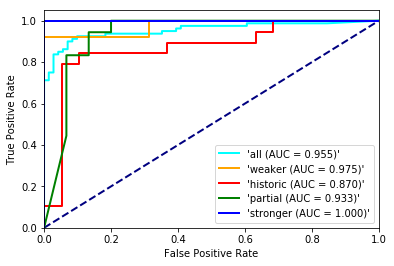

In [15]:
###plot curve 
plot_roc_curve(df_predictions_sim,datestr,write_out=1)

In [18]:
####create simulation_performance_dataframe
df_roc=simulation_performance_dataframe(df_predictions_sim,datestr,write_out=1)
df_roc

#####

sel_historic
()
[[18  1]
 [ 6 13]]
()
TPR = 68.42, TNR = 94.74, ACC = 81.58
(38, 0.8157894736842105, 0.6842105263157895, 0.9473684210526315, 'final values')
sel_weak
()
[[16  0]
 [ 4 21]]
()
TPR = 84.00, TNR = 100.00, ACC = 90.24
(41, 0.9024390243902439, 0.84, 1.0, 'final values')
sel_strong
()
[[19  2]
 [ 0 19]]
()
TPR = 100.00, TNR = 90.48, ACC = 95.00
(40, 0.95, 1.0, 0.9047619047619048, 'final values')
sel_partial
()
[[13  2]
 [ 2 16]]
()
TPR = 88.89, TNR = 86.67, ACC = 87.88
(33, 0.8787878787878788, 0.8888888888888888, 0.8666666666666667, 'final values')
all
()
[[66  5]
 [ 8 72]]
()
TPR = 90.00, TNR = 92.96, ACC = 91.39
(151, 0.9139072847682119, 0.9, 0.9295774647887324, 'final values')


,n_samples,Accuracy,TPR,TNR,AUC
sel_historic,38.0,81.578947,68.421053,94.736842,0.0
sel_weak,41.0,90.243902,84.000000,100.000000,0.0
sel_strong,40.0,95.000000,100.000000,90.476190,0.0
sel_partial,33.0,87.878788,88.888889,86.666667,0.0
all,151.0,91.390728,90.000000,92.957746,0.0
